In [1]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import os
import sys
import re
project_root = os.path.dirname(os.path.dirname(os.path.abspath('Pheno.ipynb')))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)
plt.style.use('default')
%load_ext autoreload 
%autoreload 2

In [2]:
TNBC_adata = sc.read_h5ad('../data/TNBC_adata/NTImg0001.h5ad')
TNBC_adata

AnnData object with n_obs × n_vars = 290 × 46
    obs: 'BiopsyPhase', 'PatientID', 'ImageNumber', 'ImageID', 'ObjectNumber', 'CellClusters', 'AreaShape_Area', 'isEpithelial', 'Label', 'Colour', 'PrintOrder', 'cellAnnotation', 'SpatialCluster', 'Spatial_Ratio'
    var: 'gene'
    uns: 'spatial_neighbors'
    obsm: 'X_cellcharter', 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [3]:
cells = pd.read_csv('../data/TNBC_raw/cells.csv')
cells

,BiopsyPhase,PatientID,ImageNumber,ImageID,ObjectNumber,CellClusters,AreaShape_Area,isEpithelial,Label,Colour,...,Vimentin,Calponin,Caveolin-1,CD15,MPO,HLA-DR,CD68,pH2AX,CD45,CA9
0,On-treatment,NT008,1,NTImg0001,1,3,40,False,Fibroblasts,#CDAABA,...,1.089647,1.225275,0.000052,0.000003,0.000000e+00,0.000000e+00,3.036761e-06,3.623088e-07,3.530078e-07,0.000004
1,On-treatment,NT008,1,NTImg0001,2,8,97,False,DCs,#FF9400,...,3.668336,0.649361,0.000032,0.000003,1.101167e-06,9.933202e-05,2.987009e-05,2.784882e-07,4.879576e-06,0.000001
2,On-treatment,NT008,1,NTImg0001,4,1,40,False,CA9^+,#750215,...,2.102184,1.287953,0.000050,0.000004,1.525902e-06,5.698302e-06,5.516431e-06,1.869133e-06,6.486504e-07,0.000036
3,On-treatment,NT008,1,NTImg0001,5,1,47,False,CA9^+,#750215,...,2.816998,2.945091,0.000093,0.000002,1.623300e-06,7.971884e-05,3.175431e-05,1.377950e-06,7.120148e-06,0.000085
4,On-treatment,NT008,1,NTImg0001,9,2,31,False,PDPN^+Stromal,#FE99AC,...,0.928723,1.678344,0.000080,0.000001,4.922265e-07,4.890049e-07,9.349693e-07,0.000000e+00,0.000000e+00,0.000032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2543170,On-treatment,NT091,1889,NTImg1889,1658,6,91,False,Endothelial,#FB321E,...,2.391156,0.551273,0.000090,0.000009,2.179860e-06,7.086111e-05,1.713713e-05,2.406447e-06,9.377881e-06,0.000006
2543171,On-treatment,NT091,1889,NTImg1889,1659,8,73,False,DCs,#FF9400,...,1.088931,0.770366,0.000035,0.000013,2.717360e-06,2.197874e-04,2.553680e-05,1.702265e-06,2.671910e-05,0.000004
2543172,On-treatment,NT091,1889,NTImg1889,1661,3,34,False,Fibroblasts,#CDAABA,...,2.456561,1.183453,0.000031,0.000004,2.692769e-06,1.609981e-05,1.258582e-05,1.266490e-06,1.110854e-05,0.000002
2543173,On-treatment,NT091,1889,NTImg1889,1663,15,38,False,CD4^+PD1^+T,#328A6B,...,0.861024,0.823331,0.000033,0.000032,2.409319e-06,1.040575e-05,5.143531e-06,1.570641e-06,7.016587e-05,0.000001


In [26]:
image_id = (cells[['ImageID']].value_counts() > 360).reset_index().query('count==True')['ImageID'].values
len(image_id)

1762

In [24]:
celltype_mapping = {cells['Label'].astype('category').cat.categories[i]:i for i in range(len(cells['Label'].astype('category').cat.categories))}

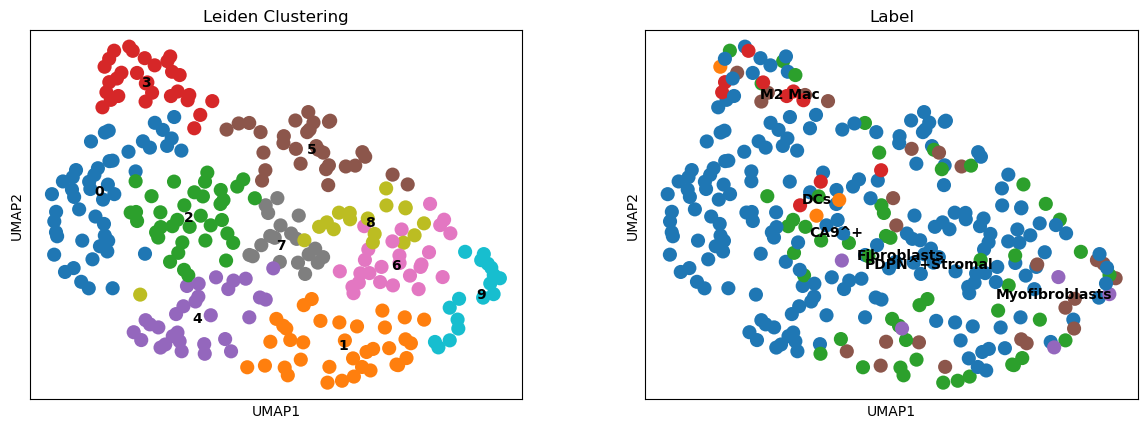

In [345]:
sc.pp.normalize_total(TNBC_adata, target_sum=1e4)
sc.pp.log1p(TNBC_adata)
sc.pp.pca(TNBC_adata)
sc.pp.neighbors(TNBC_adata)
sc.tl.umap(TNBC_adata)
sc.tl.leiden(TNBC_adata)
sc.pl.umap(TNBC_adata, color=['leiden', 'Label'], legend_loc='on data', title='Leiden Clustering')

In [27]:
clinical_data = pd.read_csv('../data/TNBC_raw/clinical.csv')
clinical_data = clinical_data.query('BiopsyPhase != "Post-treatment" and Arm == "C&I"')
clinical_data
id_data = pd.read_csv('../data/TNBC_raw/IDs.csv')
id_data = id_data.query('ImageID in @image_id')
id_data = id_data.query('BiopsyPhase != "Post-treatment"')
id_data
clinical_final = pd.merge(clinical_data[['PatientID', 'pCR']], id_data, on='PatientID')
clinical_final
# clinical_data=clinical_data.query('ImageID in @image_id')
# clinical_data.value_counts('BiopsyPhase')

,PatientID,pCR,ImageID,ImageNumber,BiopsyPhase
0,NT169,RD,NTImg0597,597,Baseline
1,NT169,RD,NTImg0598,598,Baseline
2,NT169,RD,NTImg0599,599,Baseline
3,NT169,RD,NTImg0600,600,On-treatment
4,NT169,RD,NTImg0601,601,On-treatment
...,...,...,...,...,...
1251,NT014,RD,NTImg1867,1867,Baseline
1252,NT014,RD,NTImg1868,1868,Baseline
1253,NT014,RD,NTImg1869,1869,Baseline
1254,NT014,RD,NTImg1870,1870,On-treatment


In [28]:
use_for_split=clinical_final[['PatientID', 'pCR']].drop_duplicates()
use_for_split.value_counts('pCR', normalize=True)

pCR
RD     0.526718
pCR    0.473282
Name: proportion, dtype: float64

In [29]:
from sklearn.model_selection import train_test_split
train_val_labels, test_labels = train_test_split(use_for_split, test_size=0.1, random_state=42, stratify=use_for_split['pCR'])
train_labels, val_labels = train_test_split(train_val_labels, test_size=0.1, random_state=42, stratify=train_val_labels['pCR'])

In [30]:
train_labels=train_labels.merge(clinical_final[['PatientID', 'ImageID', 'BiopsyPhase']]).query('BiopsyPhase!="Post-treatment"')
val_labels=val_labels.merge(clinical_final[['PatientID', 'ImageID', 'BiopsyPhase']]).query('BiopsyPhase!="Post-treatment"')
test_labels=test_labels.merge(clinical_final[['PatientID', 'ImageID', 'BiopsyPhase']]).query('BiopsyPhase!="Post-treatment"')

In [31]:
train_labels.to_csv('../data/TNBC_raw/train_labels.csv', index=False)
val_labels.to_csv('../data/TNBC_raw/val_labels.csv', index=False)
test_labels.to_csv('../data/TNBC_raw/test_labels.csv', index=False)

In [10]:
cellcat=cells['Label'].astype('category').cat.categories
cellcat = cellcat.values.reshape(-1,1)

In [11]:
encoder = OneHotEncoder()
encoder.fit(cellcat)

OneHotEncoder()

In [37]:
from torch_geometric.data import DataLoader, InMemoryDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os.path as osp
class TNBCDataset(InMemoryDataset):
    def __init__(self, root, adata_dir, label_dir, training='train', transform=None, pre_transform=None):
        self.name = 'TNBC'
        self.adata_dir = adata_dir
        self.label_dir = label_dir
        self.training = training
        super(TNBCDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_dir(self):
        return osp.join(self.root, self.name, 'raw')

    @property
    def processed_dir(self):
        return osp.join(self.root, self.name, 'processed')

    @property
    def raw_file_names(self):
        return [self.label_dir]

    @property
    def processed_file_names(self):
        if self.training == 'train':
            return ['training.pt']
        elif self.training == 'val':
            return ['val.pt']
        else:
            return ['test.pt']

    def download(self):
        # Download your raw data here, if necessary.
        pass

    def process(self):
        # Read the labels
        labels = pd.read_csv(self.label_dir)
        encoder = OneHotEncoder()
        cells = pd.read_csv('../data/TNBC_raw/cells.csv')
        encoder.fit(cells['Label'].values.reshape(-1, 1))
        # labels = labels.query('isPerProtocol == True & Arm == "C&I" & BiopsyPhase != "Post-treatment"')
        labels['pCR'] = labels['pCR'].map({'pCR': 1, 'RD': 0})
        remained_images = labels['ImageID'].drop_duplicates().values
        
        # Create a list of Data objects
        data_list = []
        for image_id in remained_images:
            adata = sc.read_h5ad(f'{self.adata_dir}/{image_id}.h5ad')
            edge_idx, edge_attr = from_scipy_sparse_matrix(adata.obsp['spatial_distances'])
            edge_attr=edge_attr.unsqueeze(-1)
            edge_attr = torch.tensor(edge_attr, dtype=torch.float)
            y = labels.query(f'ImageID == "{image_id}"')['pCR'].values[0]
            feature = encoder.transform(adata.obs['Label'].values.reshape(-1, 1))
            feature = torch.tensor(feature.toarray(), dtype=torch.float)
            graph_data = Data(x=feature, edge_index=edge_idx, edge_attr=edge_attr, y=torch.tensor(y, dtype=torch.long).view(-1, 1), image_id = image_id)
            data_list.append(graph_data)

        # Process data and store it
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [38]:

train_dataset = TNBCDataset(root='../data', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv', training='train')
val_dataset = TNBCDataset(root='../data', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/val_labels.csv', training='val')
test_dataset = TNBCDataset(root='../data', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training='test')

Processing...
/tmp/ipykernel_56748/2471265258.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)
/tmp/ipykernel_56748/2471265258.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)
/tmp/ipykernel_56748/2471265258.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  edge_attr = torch.tensor(edge_attr, dtype=torch.float)
/tmp/ipykernel_56748/2471265258.py:54: UserWarning: To copy construct from a tensor, it is recommended to use 

In [23]:
train_dataset[0]
len(train_dataset), len(val_dataset), len(test_dataset)

(1009, 118, 129)

In [34]:

# train_X = [data.x.numpy().mean(0).reshape(1,-1) for data in train_dataset]
# train_X = np.concatenate(train_X, axis=0)
# train_X.sum(1)
train_y

[array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([1]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),
 array([0]),

In [39]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report
# train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
# test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_X = [data.x.numpy().mean(0).reshape(1,-1) for data in train_dataset]
train_y = [data.y.numpy()[0] for data in train_dataset]
val_X = [data.x.numpy().mean(0).reshape(1,-1) for data in val_dataset]
val_y = [data.y.numpy()[0] for data in val_dataset]
test_X = [data.x.numpy().mean(0).reshape(1,-1) for data in test_dataset]
test_y = [data.y.numpy()[0] for data in test_dataset]

train_X = np.concatenate(train_X, axis=0)
test_X = np.concatenate(test_X, axis=0)
val_X = np.concatenate(val_X, axis=0)

clf = SVC(probability=True)
# clf = GradientBoostingClassifier(n_estimators=1000)
clf.fit(train_X, train_y)
train_pred = clf.predict(train_X)
val_pred = clf.predict(val_X)
test_pred = clf.predict(test_X)
test_probs = clf.predict_proba(test_X)[:, 1]
val_probs = clf.predict_proba(val_X)[:, 1]
train_probs = clf.predict_proba(train_X)[:, 1]
auc_train = roc_auc_score(train_y, train_probs)
auc_val = roc_auc_score(val_y, val_probs)
auc_test = roc_auc_score(test_y, test_probs)
print('Train Accuracy:', accuracy_score(train_y, train_pred))
print('Val Accuracy:', accuracy_score(val_y, val_pred))
print('Test Accuracy:', accuracy_score(test_y, test_pred))
print('Train AUC:', auc_train)
print('Val AUC:', auc_val)
print('Test AUC:', auc_test)
print('Classification Report:')
print(classification_report(test_y, test_pred))
print('Val Classification Report:')
print(classification_report(val_y, val_pred))


Train Accuracy: 0.8333333333333334
Val Accuracy: 0.5967741935483871
Test Accuracy: 0.7083333333333334
Train AUC: 0.9227066241779103
Val AUC: 0.5483193277310925
Test AUC: 0.7171875000000001
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        40
           1       0.68      0.66      0.67        32

    accuracy                           0.71        72
   macro avg       0.70      0.70      0.70        72
weighted avg       0.71      0.71      0.71        72

Val Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        34
           1       0.55      0.57      0.56        28

    accuracy                           0.60        62
   macro avg       0.59      0.59      0.59        62
weighted avg       0.60      0.60      0.60        62



/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [21]:
adata_list = os.listdir('../data/TNBC_adata')
from tqdm import tqdm
for adata in tqdm(adata_list):
    new_ad = sc.read_h5ad(f'../data/TNBC_adata/{adata}')
    sq.gr.spatial_neighbors(new_ad, coord_type='generic', delaunay=True)
    new_ad.write_h5ad(f'../data/TNBC_adata/{adata}')



100%|██████████| 1855/1855 [03:52<00:00,  7.96it/s]


In [25]:
from model import Subgraph
model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=32, cls_hidden=16, number_of_features=TNBC_adata.X.shape[1])

In [202]:
import torch.nn.functional as F
logits = torch.randn(2, 2)
print(logits)

print(F.softmax(logits, dim=1))

tensor([[-0.1188,  0.2047],
        [ 0.1102,  0.4824]])
tensor([[0.4198, 0.5802],
        [0.4080, 0.5920]])


In [240]:
uu= torch.tensor([0, 100], dtype=torch.float32)
F.gumbel_softmax(uu, tau=1, hard=False)

tensor([1.4013e-44, 1.0000e+00])

0.423728813559322
118
1368.3559322033898
550.1390198021558
386 2533


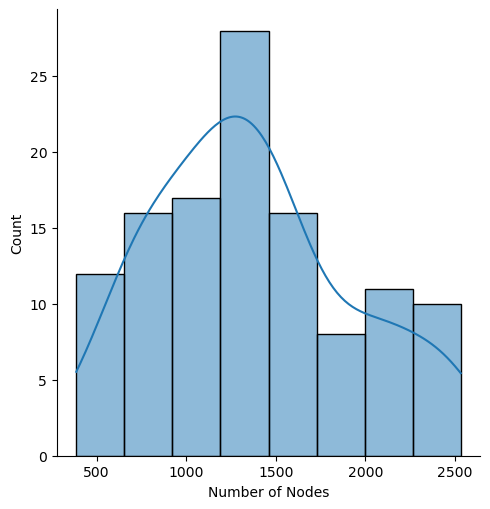

In [54]:
num_nodes = []
pCR_num = 0
for data in val_dataset:
    num_nodes.append(data.num_nodes)
    pCR_num += data.y.sum().item()
print(pCR_num/len(val_dataset))
print(len(num_nodes))
print(np.mean(num_nodes))
print(np.std(num_nodes))
print(np.min(num_nodes), np.max(num_nodes))
sns.displot(num_nodes, kde=True)
plt.xlabel('Number of Nodes')
plt.show()

In [28]:
import torch
from model import Subgraph
from torch_geometric.data import DataLoader

# train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
# test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
# Ensure to adjust root, adata_dir, label_dir to your configurations
# dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/Cleaned_data/TNBC/clinical_data.csv')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=37)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

train_accs = []
test_accs = []
kl_losses = []
cls_losses = []
positive_penalties = []
test_preserve_rate_list = []
train_preserve_rate_list = []
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    train_preserve_rate = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        _, _, _, kl_loss, cls_loss, positive_penalty, preserve_rate, correct_num = model(data)

        # kl_weight = (1e-4 / 2) * (1 + np.sin(2 * np.pi * (epoch % 40) / 40))
        # if epoch < 100:
        loss = cls_loss + kl_loss * 0.00004 + positive_penalty * 5 # Adjust loss composition as needed
        # else:
        #     loss = cls_loss + kl_loss * min(0.00001, 0.00001 * epoch/200) + positive_penalty * 5 # Adjust loss composition as needed
        total_loss += loss
        train_acc_num += correct_num / 2
        loss.backward()
        optimizer.step()
        kl_losses.append(kl_loss.item() * 0.000004)
        cls_losses.append(cls_loss.item())
        positive_penalties.append(positive_penalty.item())
        train_preserve_rate += preserve_rate
    print(f'Train Preserve Rate: {train_preserve_rate / len(train_loader)}')
    train_preserve_rate_list.append(train_preserve_rate / len(train_loader))
    train_acc = train_acc_num / len(train_dataset)
    test_preserve_rate = 0
    for data in test_loader:
        data = data.to(device)
        correct_num, cls_loss, preserve_rate = model.test(data)
        test_acc_num += correct_num
        test_preserve_rate += preserve_rate
    test_preserve_rate_list.append(test_preserve_rate / len(test_loader))
    test_acc = test_acc_num / len(test_dataset)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(train_dataset)}, Classification loss: {cls_losses[-1]}, kl_loss: {kl_losses[-1]}, Train Acc: {train_acc}, Test Acc: {test_acc}, Test Preserve Rate: {test_preserve_rate_list[-1]}')

Train Preserve Rate: 0.0
Epoch 0, Loss: 0.2504148606148182, Classification loss: 0.00014953172649256885, kl_loss: 0.00198990234375, Train Acc: 0.535183349851338, Test Acc: 0.689922480620155, Test Preserve Rate: 0.0
Train Preserve Rate: 0.0
Epoch 1, Loss: 0.18805374735292524, Classification loss: 1.193514108657837, kl_loss: 0.00125518994140625, Train Acc: 0.6025768087215064, Test Acc: 0.7131782945736435, Test Preserve Rate: 0.0
Train Preserve Rate: 0.0
Epoch 2, Loss: 0.16956478304149375, Classification loss: 0.5741502642631531, kl_loss: 0.0007693238525390625, Train Acc: 0.6144697720515362, Test Acc: 0.7131782945736435, Test Preserve Rate: 0.0
Train Preserve Rate: 0.00023669338130709544
Epoch 3, Loss: 0.15626574271497926, Classification loss: 0.17271152138710022, kl_loss: 0.0016544195556640624, Train Acc: 0.6194251734390486, Test Acc: 0.6976744186046512, Test Preserve Rate: 8.551855752698335e-05
Train Preserve Rate: 0.0007722646481227075
Epoch 4, Loss: 0.15043369440659068, Classification

In [29]:
# train_accs = [x.item() for x in train_accs]
# test_accs = [x.item() for x in test_accs]
train_accs = np.array(train_accs)
test_accs = np.array(test_accs)


Text(0.5, 1.0, 'Training and Test Accuracy')

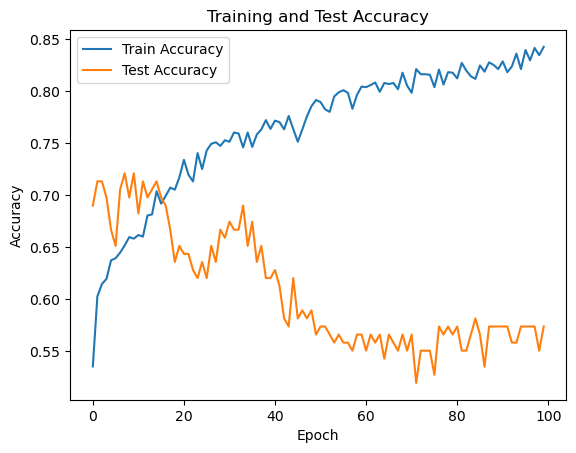

In [30]:
sns.lineplot(x=range(len(train_accs)), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(len(test_accs)), y=test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')

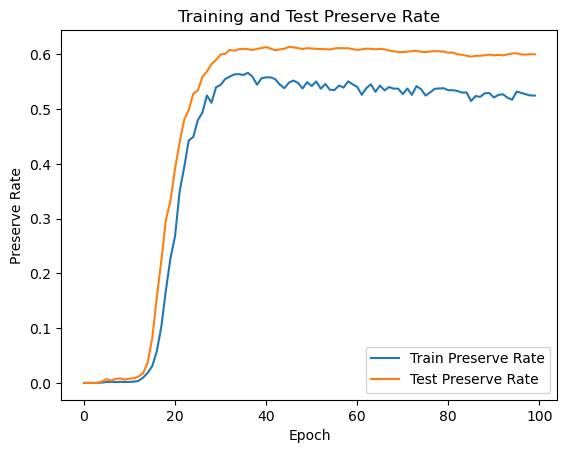

In [31]:
sns.lineplot(x=range(len(train_preserve_rate_list)), y=train_preserve_rate_list, label='Train Preserve Rate')
sns.lineplot(x=range(len(test_preserve_rate_list)), y=test_preserve_rate_list, label='Test Preserve Rate')
plt.xlabel('Epoch')
plt.ylabel('Preserve Rate')
plt.title('Training and Test Preserve Rate')
plt.show()

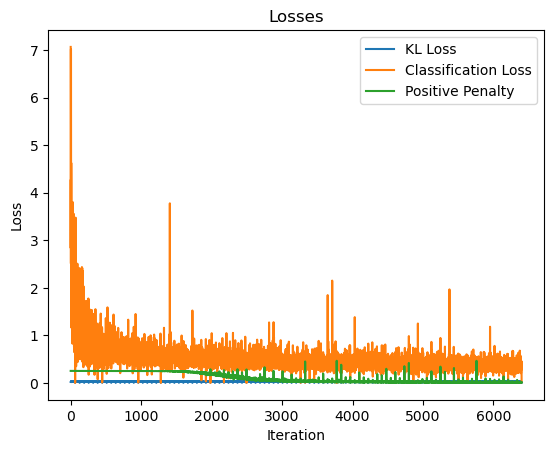

In [32]:
sns.lineplot(x=range(len(kl_losses)), y=kl_losses, label='KL Loss')
sns.lineplot(x=range(len(cls_losses)), y=cls_losses, label='Classification Loss')
sns.lineplot(x=range(len(positive_penalties)), y=positive_penalties, label='Positive Penalty')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()
plt.show()

In [376]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='..', name='MUTAG')
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [374]:
num_nodes = []
for data in dataset:
    num_nodes.append(data.num_nodes)
print(sum(num_nodes)/len(num_nodes))
print(np.std(num_nodes))
print(np.min(num_nodes), np.max(num_nodes))

17.930851063829788
4.575664737098715
10 28


In [410]:
from model import Subgraph, BaselineGNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=7)

# model = BaselineGNN(gcn_first=32, gcn_second=32, fc_1=64, fc_2=2, cls_hidden=128, number_of_features=7)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_accs = []
test_accs = []
cls_losses = []
kl_losses = []
positive_penalties = []
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    train_preserve_rate = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)

        _, _, _, kl_loss, cls_loss, positive_penalty, preserve_rate, correct_num = model(data)
        if epoch < 50:
            loss = cls_loss + positive_penalty
        else:
            loss =  cls_loss + kl_loss* 1 + positive_penalty # Adjust loss composition as needed
        train_acc_num += correct_num / 2
        train_preserve_rate += preserve_rate
        total_loss += loss
        loss.backward()
        optimizer.step()
        cls_losses.append(cls_loss.item())
        kl_losses.append(kl_loss.item())
        positive_penalties.append(positive_penalty.item())
    train_acc = train_acc_num / len(dataset)
    print(f'Train Preserve Rate: {train_preserve_rate / len(train_loader)}')
    train_accs.append(train_acc)
    test_preserve_rate = 0
    for data in train_loader:
        data = data.to(device)
        correct_num, cls_loss, preserve_rate = model.test(data)
        test_preserve_rate += preserve_rate
        test_acc_num += correct_num
    test_acc = test_acc_num / len(dataset)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(dataset)}, Train Acc: {train_acc}, Test Acc: {test_acc}, Test Preserve Rate: {test_preserve_rate / len(train_loader)}')
    


RuntimeError: mat1 and mat2 shapes cannot be multiplied (21563x37 and 7x32)

Text(0.5, 1.0, 'Training and Test Accuracy')

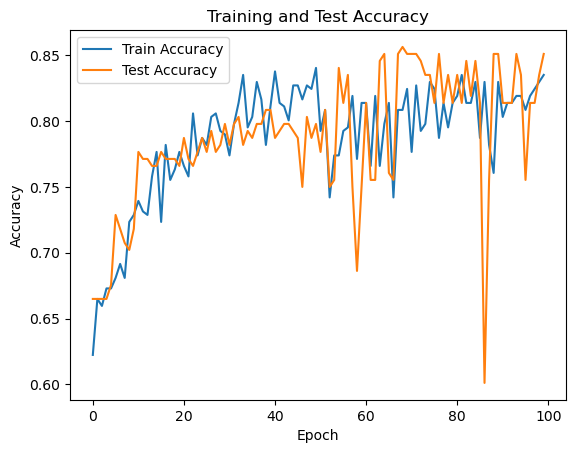

In [378]:
sns.lineplot(x=range(len(train_accs)), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(len(test_accs)), y=test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')


Text(0.5, 1.0, 'Losses')

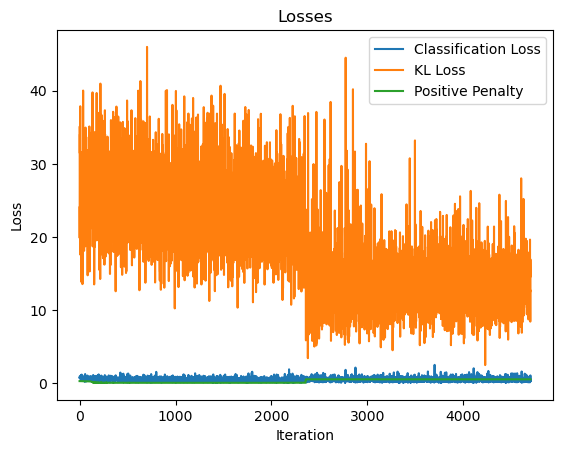

In [379]:
sns.lineplot(x=range(len(cls_losses)), y=cls_losses, label='Classification Loss')
sns.lineplot(x=range(len(kl_losses)), y=kl_losses, label='KL Loss')
sns.lineplot(x=range(len(positive_penalties)), y=positive_penalties, label='Positive Penalty')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Losses')


In [17]:
from model import Subgraph, BaselineGNN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model = Subgraph(gcn_first=64, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=64, number_of_features=7)

model = BaselineGNN(gcn_first=32, gcn_second=32, fc_1=64, fc_2=2, cls_hidden=128, number_of_features=7)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_accs = []
test_accs = []
gradient_accumulation_steps = 8
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    test_acc_num = 0
    gradient_i = 0
    for data in dataset:
        optimizer.zero_grad()
        data = data.to(device)

        graph_embedding, cls_loss, correct_num, probs = model(data)
        loss =  cls_loss # Adjust loss composition as needed
        train_acc_num += correct_num
        total_loss += loss
        loss.backward()
        optimizer.step()
    train_acc = train_acc_num / len(dataset)
    train_accs.append(train_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(dataset)}, Train Acc: {train_acc}')
    


Epoch 0, Loss: 0.6005210064827128, Train Acc: 0.6914893388748169
Epoch 1, Loss: 0.5546687917506441, Train Acc: 0.7180851101875305
Epoch 2, Loss: 0.5301228381217794, Train Acc: 0.7234042286872864
Epoch 3, Loss: 0.5150877769957197, Train Acc: 0.7553191184997559
Epoch 4, Loss: 0.5284293154452709, Train Acc: 0.7553191184997559
Epoch 5, Loss: 0.5176098194528134, Train Acc: 0.7659574151039124
Epoch 6, Loss: 0.5070707848731507, Train Acc: 0.7553191184997559
Epoch 7, Loss: 0.49946898602424783, Train Acc: 0.771276593208313
Epoch 8, Loss: 0.4941808822307181, Train Acc: 0.7659574151039124
Epoch 9, Loss: 0.4890551059804064, Train Acc: 0.7819148898124695
Epoch 10, Loss: 0.48391151428222656, Train Acc: 0.7819148898124695
Epoch 11, Loss: 0.4770393777400889, Train Acc: 0.7872340083122253
Epoch 12, Loss: 0.47356808439214176, Train Acc: 0.7872340083122253
Epoch 13, Loss: 0.47227616005755485, Train Acc: 0.7819148898124695
Epoch 14, Loss: 0.46686898901107465, Train Acc: 0.7819148898124695
Epoch 15, Loss: 

In [39]:
from model import BaselineGNN
from sklearn.metrics import roc_auc_score, f1_score
from torch_geometric.data import DataLoader
# train_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/train_labels.csv')
# test_dataset = GraphDataset(root='..', adata_dir='../data/TNBC_adata', label_dir='../data/TNBC_raw/test_labels.csv', training=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BaselineGNN(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=32, number_of_features=37)

# model = Subgraph(gcn_first=16, gcn_second=16, fc_1=32, fc_2=2, cls_hidden=128, number_of_features=37)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
train_accs = []
val_accs = []
test_accs = []
train_losses = []
val_losses = []
test_losses = []
train_f1s = []
val_f1s = []
test_f1s = []
for epoch in range(100):  # Example: 100 epochs
    model.train()
    total_loss = 0
    train_acc_num = 0
    val_acc_num = 0
    test_acc_num = 0
    train_label = []
    train_probs = []
    val_label = []
    val_probs = []
    test_label = []
    test_probs = []
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        _, loss, correct_num, probs = model(data)
        train_acc_num += correct_num
        total_loss += loss
        loss.backward()
        optimizer.step()
        probs = probs.cpu().detach().numpy()[:, 1]
        train_label.extend(data.y.cpu().numpy())
        train_probs.extend(probs)
    print('Train AUC:', roc_auc_score(train_label, train_probs))
    print('Train F1: ', f1_score(train_label, np.array(train_probs) > 0.5))
    train_f1s.append(f1_score(train_label, np.array(train_probs) > 0.5))
    train_acc = train_acc_num / len(train_dataset)
    for data in val_loader:
        data = data.to(device)
        _, loss, correct_num, probs = model(data)
        val_acc_num += correct_num
        probs = probs.cpu().detach().numpy()[:, 1]
        val_probs.extend(probs)
        val_label.extend(data.y.cpu().numpy())
    print('Val AUC:', roc_auc_score(val_label, val_probs))
    print('Val F1: ', f1_score(val_label, np.array(val_probs) > 0.5))
    val_f1s.append(f1_score(val_label, np.array(val_probs) > 0.5))
    val_acc = val_acc_num / len(val_dataset)
    val_accs.append(val_acc)
    for data in test_loader:
        data = data.to(device)
        _, loss, correct_num, probs = model(data)
        test_acc_num += correct_num
        probs = probs.cpu().detach().numpy()[:, 1]
        test_probs.extend(probs)
        test_label.extend(data.y.cpu().numpy())
    print('Test AUC:', roc_auc_score(test_label, test_probs))
    print('Test F1: ', f1_score(test_label, np.array(test_probs) > 0.5))
    test_f1s.append(f1_score(test_label, np.array(test_probs) > 0.5))
    test_acc = test_acc_num / len(test_dataset)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Epoch {epoch}, Loss: {total_loss.item()/len(train_dataset)}, Train Acc: {train_acc}, Test Acc: {test_acc}')
    


/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Train AUC: 0.6135251015266752
Train F1:  0.5429184549356223
Val AUC: 0.6205882352941177
Val F1:  0.5346534653465347
Test AUC: 0.6970515970515971
Test F1:  0.5233644859813084
Epoch 0, Loss: 0.11009471881968533, Train Acc: 0.5777997970581055, Test Acc: 0.604651153087616
Train AUC: 0.7200327428494226
Train F1:  0.6017699115044248
Val AUC: 0.5305882352941177
Val F1:  0.4
Test AUC: 0.6734643734643735
Test F1:  0.40860215053763443
Epoch 1, Loss: 0.045476922903826496, Train Acc: 0.6432111263275146, Test Acc: 0.5736433863639832
Train AUC: 0.8021918635608642
Train F1:  0.6908267270668177
Val AUC: 0.5911764705882353
Val F1:  0.5050505050505051
Test AUC: 0.714987714987715
Test F1:  0.5932203389830508
Epoch 2, Loss: 0.03630727913500178, Train Acc: 0.7294350862503052, Test Acc: 0.6279069781303406
Train AUC: 0.8151578729863547
Train F1:  0.6788154897494305
Val AUC: 0.5370588235294117
Val F1:  0.48148148148148145
Test AUC: 0.7144963144963145
Test F1:  0.6
Epoch 3, Loss: 0.0349564112804099, Train Acc:

Text(0.5, 1.0, 'Training and Test Accuracy')

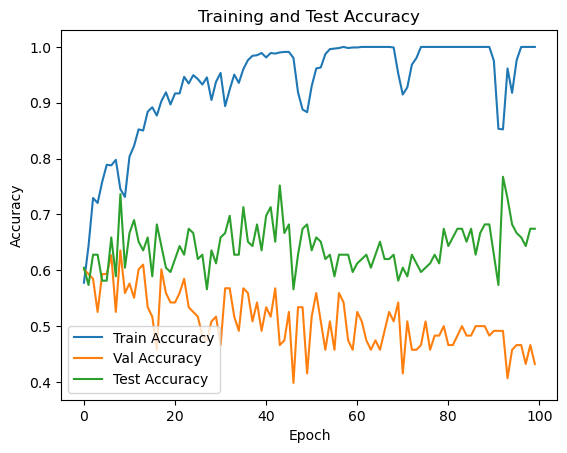

In [40]:
train_accs = [x.item() for x in train_accs]
val_accs = [x.item() for x in val_accs]
test_accs = [x.item() for x in test_accs]
sns.lineplot(x=range(len(train_accs)), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(len(val_accs)), y=val_accs, label='Val Accuracy')
sns.lineplot(x=range(len(test_accs)), y=test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')

Text(0.5, 1.0, 'Training and Test F1')

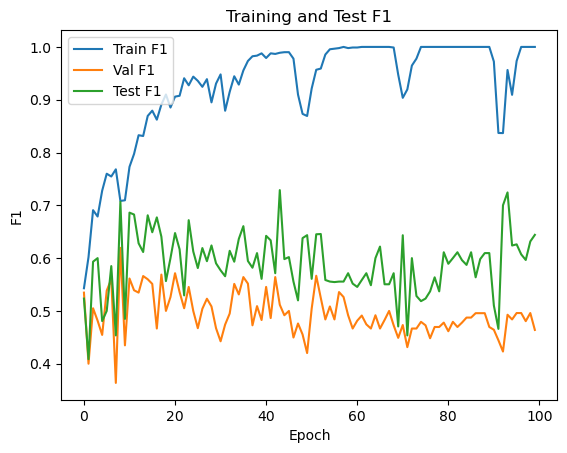

In [41]:
sns.lineplot(x=range(len(train_f1s)), y=train_f1s, label='Train F1')
sns.lineplot(x=range(len(val_f1s)), y=val_f1s, label='Val F1')
sns.lineplot(x=range(len(test_f1s)), y=test_f1s, label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.title('Training and Test F1')